In [1]:
# make visible the only one GPU
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


In [2]:
# !pip install soundfile

In [3]:
import urllib.request
import io
import soundfile as sf
import numpy as np
import matplotlib.pyplot as plt
import IPython
%matplotlib inline

In [4]:
import tensorflow as tf

In [5]:
print(tf.__version__)

2.0.0-dev20190510


### download and load the waveform

In [6]:
url = "https://raw.githubusercontent.com/timsainb/python_spectrograms_and_inversion/master/bushOffersPeace.wav"

In [7]:
response = urllib.request.urlopen(url)
data, samplerate = sf.read(io.BytesIO(response.read()))

In [8]:
IPython.display.Audio(data=data, rate=samplerate)

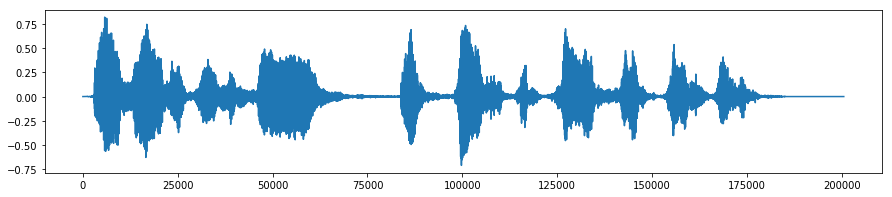

In [9]:
fig, ax = plt.subplots(ncols=1, figsize=(15,3))
ax.plot(data)

### Create the spectrogram
These are a set of spectrogramming functions in tensorflow. They are largely based on [keithito's implementation of tacotron](https://github.com/keithito/tacotron/blob/master/util/audio.py) and [Kyubyong's spectrogramming tutorial](https://github.com/Kyubyong/tensorflow-exercises/blob/master/Audio_Processing.ipynb). Some parts are based on functions from [Librosa](https://librosa.github.io/librosa/)

In [10]:
def _normalize_tensorflow(S, hparams):
    return tf.clip_by_value((S - hparams.min_level_db) / -hparams.min_level_db, 0, 1)


def _tf_log10(x):
    numerator = tf.math.log(x)
    denominator = tf.math.log(tf.constant(10, dtype=numerator.dtype))
    return numerator / denominator


def _amp_to_db_tensorflow(x):
    return 20 * _tf_log10(tf.clip_by_value(tf.abs(x), 1e-5, 1e100))


def _stft_tensorflow(signals, hparams):
    return tf.signal.stft(
        signals,
        hparams.win_length,
        hparams.hop_length,
        hparams.n_fft,
        pad_end=True,
        window_fn=tf.signal.hann_window,
    )


def spectrogram_tensorflow(y, hparams):
    D = _stft_tensorflow(y, hparams)
    S = _amp_to_db_tensorflow(tf.abs(D)) - hparams.ref_level_db
    return _normalize_tensorflow(S, hparams)

In [11]:
class HParams(object):
    """ Hparams was removed from tf 2.0alpha so this is a placeholder
    """
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [12]:
hparams = HParams(  
    # spectrogrammign
    win_length = 2048,
    n_fft = 2048,
    hop_length=128,
    ref_level_db = 50,
    min_level_db = -100,
    # mel scaling
    num_mel_bins = 128,
    mel_lower_edge_hertz = 0,
    mel_upper_edge_hertz = 8000,
    # inversion
    power = 1, # for spectral inversion
    griffin_lim_iters = 50,
    pad=True,
    #
)

In [13]:
spectrogram = spectrogram_tensorflow(data.astype('float32'), hparams)

In [14]:
spectrogram.numpy().max(), spectrogram.numpy().min()

(0.9552964, 0.0)

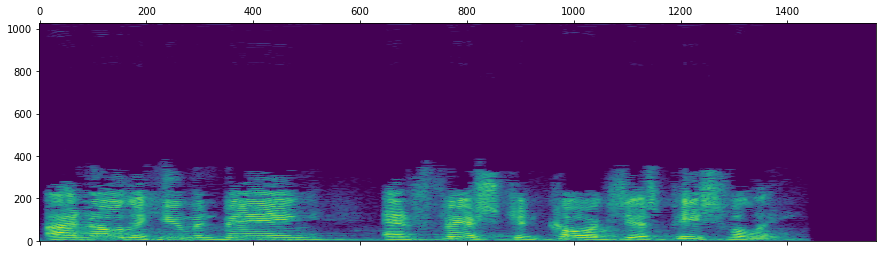

In [15]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
ax.matshow(spectrogram.numpy().T, aspect='auto', origin='lower')

### Inverting the spectrogram
**Note: at the time of writing, tf.signal.istft is broken (2.0 alpha), so I'm implementing inversion partially in numpy. This should matter much in our case because inversion is being done offline.**

In [16]:
import librosa


def _istft(y, hparams):
    return librosa.istft(
        y, hop_length=hparams.hop_length, win_length=hparams.win_length
    )


def _stft(y, hparams):
    return librosa.stft(
        y=y,
        n_fft=hparams.n_fft,
        hop_length=hparams.hop_length,
        win_length=hparams.win_length,
    )


def _db_to_amp_tensorflow(x):
    return tf.pow(tf.ones(tf.shape(x)) * 10.0, x * 0.05)


# use this one when istft is fixed!
def _istft_tensorflow(stfts, hparams):
    return tf.signal.inverse_stft(
        stfts, hparams.win_length, hparams.hop_length, hparams.n_fft
    )


def _denormalize_tensorflow(S, hparams):
    return (tf.clip_by_value(S, 0, 1) * -hparams.min_level_db) + hparams.min_level_db


def _griffin_lim_tensorflow(S, hparams, use_tf_istft=False):
    """TensorFlow implementation of Griffin-Lim
  Based on https://github.com/Kyubyong/tensorflow-exercises/blob/master/Audio_Processing.ipynb and
  https://github.com/keithito/tacotron/blob/master/util/audio.py
  issue: https://github.com/tensorflow/tensorflow/issues/28444
  """
    # TensorFlow's stft and istft operate on a batch of spectrograms; create batch of size 1
    if use_tf_istft:
        S = tf.expand_dims(S, 0)
        S_complex = tf.identity(tf.cast(S, dtype=tf.complex64))
        y = tf.py_function(_istft(S_complex, hparams))
        for i in range(hparams.griffin_lim_iters):
            est = _stft_tensorflow(y)
            angles = est / tf.cast(tf.maximum(1e-8, tf.abs(est)), tf.complex64)
            y = _istft_tensorflow(S_complex * angles, hparams)
        return tf.squeeze(y, 0)

    else:
        angles = np.exp(2j * np.pi * np.random.rand(*S.shape))
        S_complex = np.abs(S).astype(np.complex)
        y = _istft(S_complex * angles, hparams)
        for i in range(hparams.griffin_lim_iters):
            angles = np.exp(1j * np.angle(_stft(y, hparams)))
            y = _istft(S_complex * angles, hparams)
        return y


def inv_spectrogram_tensorflow(spectrogram, hparams):
    """Converts spectrogram to waveform using librosa"""
    S = _db_to_amp_tensorflow(
        _denormalize_tensorflow(spectrogram, hparams) + hparams.ref_level_db
    )  # Convert back to linear
    return _griffin_lim_tensorflow(S ** hparams.power, hparams)  # Reconstruct phase

In [17]:
def _amp_to_db_tensorflow(x):
    return 20 * _tf_log10(tf.clip_by_value(tf.abs(x), 1e-5, 1e100))



In [18]:
stft_x = tf.abs(_stft_tensorflow(data.astype('float32'), hparams))

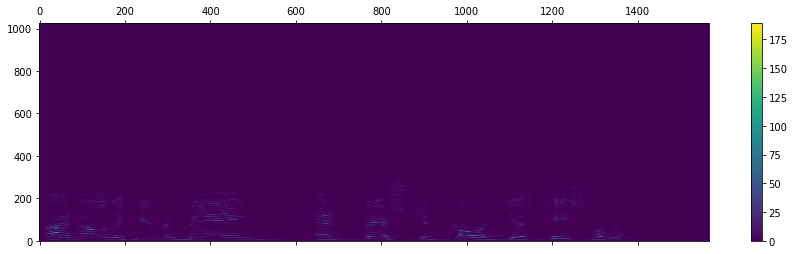

In [19]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow(stft_x.numpy().T, aspect='auto', origin='lower')
fig.colorbar(cax)

In [20]:
db_stft_x = _amp_to_db_tensorflow(stft_x)

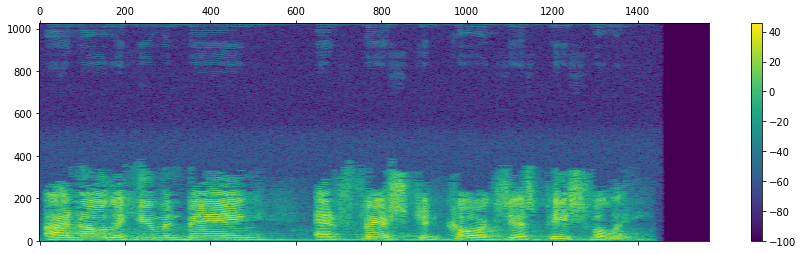

In [21]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow(db_stft_x.numpy().T, aspect='auto', origin='lower')
fig.colorbar(cax)

In [22]:
amp_stft_x = _db_to_amp_tensorflow(db_stft_x)

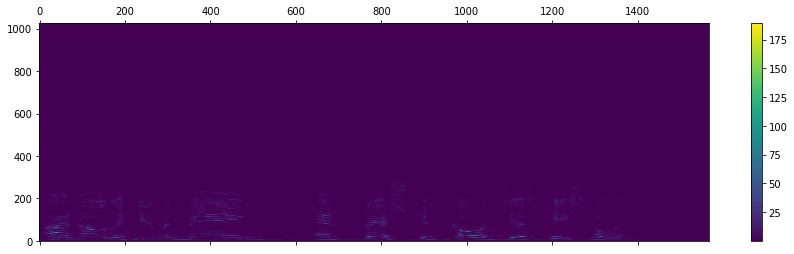

In [23]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow(amp_stft_x.numpy().T, aspect='auto', origin='lower')
fig.colorbar(cax)

In [24]:
def _normalize_tensorflow(S, hparams):
    return tf.clip_by_value((S - hparams.min_level_db) / -hparams.min_level_db, 0, 1)

In [25]:
norm_db_stft_x = _normalize_tensorflow(db_stft_x - hparams.ref_level_db, hparams)

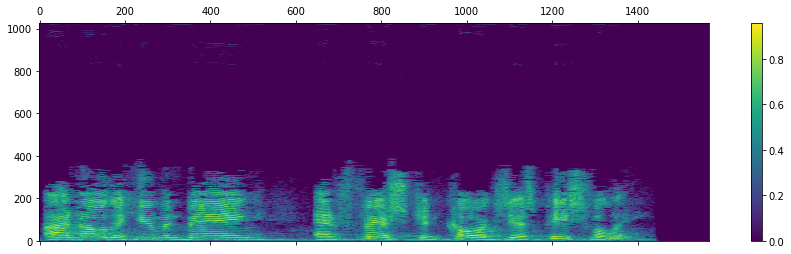

In [26]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow(norm_db_stft_x.numpy().T, aspect='auto', origin='lower')
fig.colorbar(cax)

In [27]:
def _denormalize_tensorflow(S, hparams):
    return (tf.clip_by_value(S, 0, 1) * -hparams.min_level_db) + hparams.min_level_db

In [28]:
denorm_db_stft_x = _denormalize_tensorflow(norm_db_stft_x, hparams) + hparams.ref_level_db

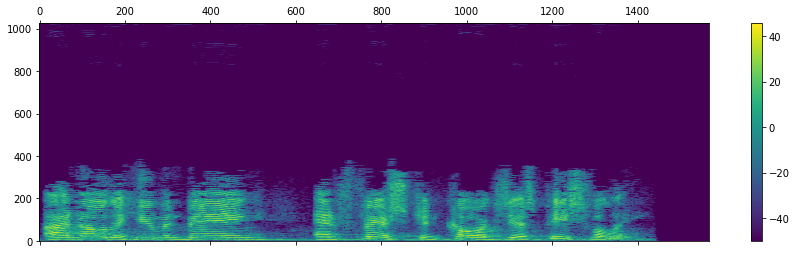

In [29]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow(denorm_db_stft_x.numpy().T, aspect='auto', origin='lower')
fig.colorbar(cax)

In [30]:
rec_amp_stft_x = _db_to_amp_tensorflow(denorm_db_stft_x)

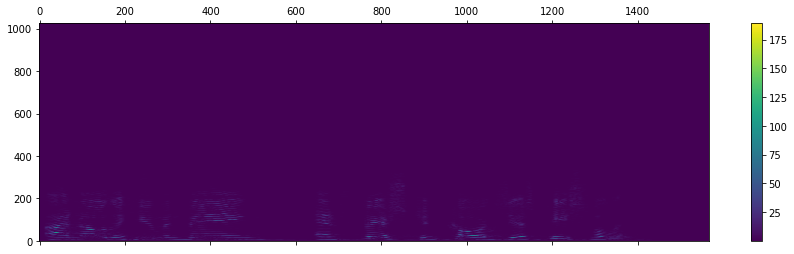

In [31]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
cax = ax.matshow(rec_amp_stft_x.numpy().T, aspect='auto', origin='lower')
fig.colorbar(cax)

In [32]:
reconstructed_y = inv_spectrogram_tensorflow(np.transpose(spectrogram), hparams)

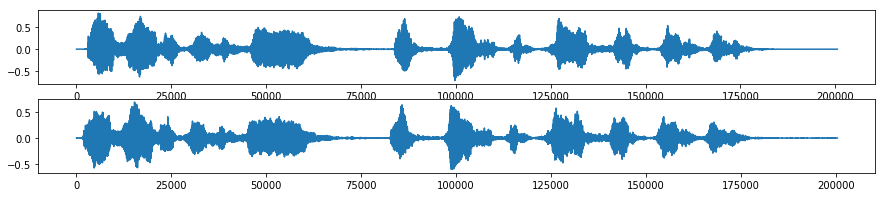

In [33]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(15,3))
axs[0].plot(data)
axs[1].plot(reconstructed_y)
IPython.display.Audio(data=reconstructed_y, rate=samplerate)

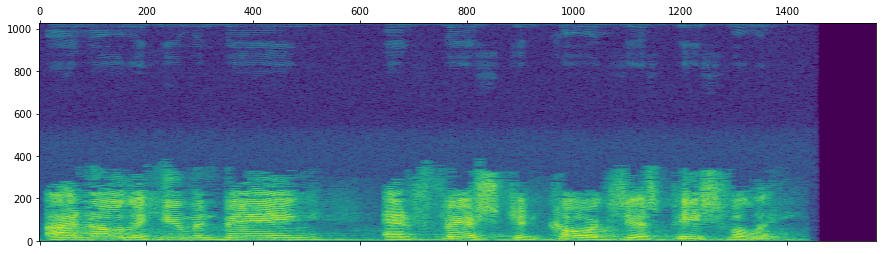

In [70]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
ax.matshow(_amp_to_db_tensorflow(stft_x).numpy().T, aspect='auto', origin='lower')

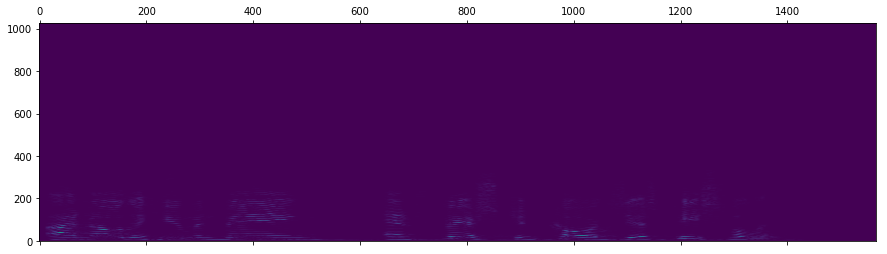

In [71]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
ax.matshow(_db_to_amp_tensorflow(_amp_to_db_tensorflow(stft_x)).numpy().T, aspect='auto', origin='lower')

In [67]:
S = _db_to_amp_tensorflow(
    _denormalize_tensorflow(np.transpose(spectrogram), hparams) + hparams.ref_level_db
)

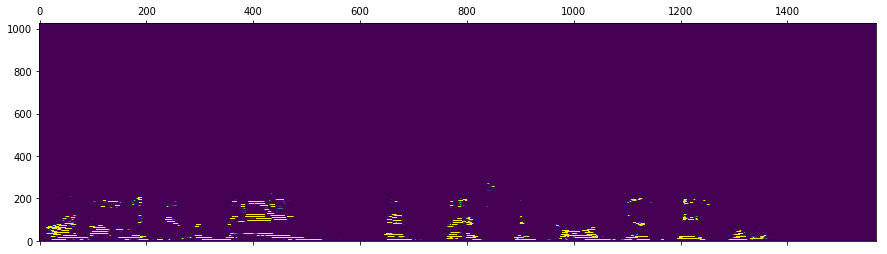

In [66]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
ax.matshow(S.numpy(), aspect='auto', origin='lower')

In [ ]:
IPython.display.Audio(data=data, rate=samplerate)

In [ ]:
def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))
    overlap_sz = window_size - window_step
    new_shape = X.shape[:-1] + ((X.shape[-1] - overlap_sz) // window_step, window_size)
    new_strides = X.strides[:-1] + (window_step * X.strides[-1],) + X.strides[-1:]
    X_strided = as_strided(X, shape=new_shape, strides=new_strides)
    return X_strided


def stft(X, fftsize=128, step="half", mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = fftpack.rfft
        cut = -1
    else:
        local_fft = fftpack.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2 + 1
    if mean_normalize:
        X -= X.mean()
    if step == "half":
        X = halfoverlap(X, fftsize)
    else:
        X = overlap(X, fftsize, step)
    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def xcorr_offset(x1, x2):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype('float32'), x2[::-1].astype('float32'))
    corrs[:half] = -1E30
    corrs[-half:] = -1E30
    offset = corrs.argmax() - len(x1)
    return offset


def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype('float64')
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print("WARNING: Large step size >50\% detected! "
                      "This code works best with high overlap - try "
                      "with 75% or greater")
                offset_size = step
            offset = xcorr_offset(wave[wave_start:wave_start + offset_size],
                                  wave_est[est_start:est_start + offset_size])
        else:
            offset = 0
        wave[wave_start:wave_end] += win * wave_est[
            est_start - offset:est_end - offset]
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1E-6)
    return wave


def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    reg = np.max(X_s) / 1e8
    X_best = copy.deepcopy(X_s)
    for i in range(n_iter):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(
                X_best, step, calculate_offset=True, set_zero_phase=True
            )
        else:
            # Calculate offset was False in the MATLAB version
            # but in mine it massively improves the result
            # Possible bug in my impl?
            X_t = invert_spectrogram(
                X_best, step, calculate_offset=True, set_zero_phase=False
            )
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s * phase[: len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True, set_zero_phase=False)
    return np.real(X_t)


In [ ]:
hparams.__dict__

In [ ]:
import copy
from scipy import linalg, fftpack
from numpy.lib.stride_tricks import as_strided


In [ ]:
X_s = S.numpy()[:1552, :1024]
X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)

In [ ]:
X_s.shape

In [ ]:
X_s.shape

In [ ]:
plt.matshow(X_s)

In [ ]:
test = iterate_invert_spectrogram(X_s, hparams.n_fft, step=hparams.hop_length)

In [ ]:
plt.plot(test)

In [ ]:
test

In [ ]:
IPython.display.Audio(data=test, rate=samplerate)

### Create the mel filter

In [ ]:
# create a filter to convolve with the spectrogram
mel_matrix = tf.signal.linear_to_mel_weight_matrix(
    num_mel_bins=hparams.num_mel_bins,
    num_spectrogram_bins=int(hparams.n_fft/2)+1,
    sample_rate=samplerate,
    lower_edge_hertz=hparams.mel_lower_edge_hertz,
    upper_edge_hertz=hparams.mel_upper_edge_hertz,
    dtype=tf.dtypes.float32,
    name=None,
)

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
ax.matshow(mel_matrix.numpy().T, aspect='auto', origin='lower')

#### This is what the mel spectrogram would look like if we didn't normalize the mel filter

In [ ]:
mel_spectrogram = tf.tensordot(spectrogram,mel_matrix, 1)

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
ax.matshow(mel_spectrogram.numpy().T, aspect='auto', origin='lower')

### Normalize the mel filter

In [ ]:
from librosa.core.time_frequency import mel_frequencies

In [ ]:
# gets the center frequencies of mel bands
mel_f = mel_frequencies(
    n_mels=hparams.num_mel_bins + 2,
    fmin=hparams.mel_lower_edge_hertz,
    fmax=hparams.mel_upper_edge_hertz,
)

In [ ]:
# Slaney-style mel is scaled to be approx constant energy per channel (from librosa)
enorm = tf.dtypes.cast(
    tf.expand_dims(tf.constant(2.0 / (mel_f[2 : n_mels + 2] - mel_f[:n_mels])), 0),
    tf.float32,
)

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(15,2))
ax.plot(enorm.numpy().T)

In [ ]:
mel_matrix = tf.multiply(mel_matrix, enorm)

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
ax.matshow(mel_matrix.numpy().T, aspect='auto', origin='lower')

### Create the Mel spectrogram

In [ ]:
mel_spectrogram = tf.tensordot(spectrogram,mel_matrix, 1)

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
ax.matshow(mel_spectrogram.numpy().T, aspect='auto', origin='lower')

### Invert the mel spectrogram

In [ ]:
with np.errstate(divide="ignore", invalid="ignore"):
    mel_inversion_matrix = tf.constant(
        np.nan_to_num(
            np.divide(mel_matrix.numpy().T, np.sum(mel_matrix.numpy(), axis=1))
        ).T
    )

In [ ]:
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
ax.matshow(mel_inversion_matrix.numpy().T, aspect='auto', origin='lower')

In [ ]:
mel_spectrogram_inv = tf.tensordot(mel_spectrogram,tf.transpose(mel_inversion_matrix), 1)

In [ ]:
# compare lower frequencies to the original
fig, ax = plt.subplots(ncols=1, figsize=(15,4))
ax.matshow(mel_spectrogram_inv.numpy().T, aspect='auto', origin='lower')

In [ ]:
# compare lower frequencies to the original
fig, axs = plt.subplots(ncols=2, figsize=(20,4))
axs[0].matshow(mel_spectrogram_inv.numpy().T[:200,:], aspect='auto', origin='lower')
axs[1].matshow(spectrogram.numpy().T[:200,:], aspect='auto', origin='lower')

### Inverting the spectrogram
**Note: at the time of writing, tf.signal.istft is broken (2.0 alpha), so I'm implementing inversion partially in numpy. This should matter much in our case because inversion is being done offline.**

In [ ]:
def _istft(y, hparams):
    return librosa.istft(
        y, hop_length=hparams.hop_length, win_length=hparams.win_length
    )

def _db_to_amp_tensorflow(x):
  return tf.pow(tf.ones(tf.shape(x)) * 10.0, x * 0.05)

# use this one when istft is fixed!
def _istft_tensorflow(stfts, hparams):
    return tf.signal.inverse_stft(
        stfts, hparams.win_length, hparams.hop_length, hparams.n_fft
    )

def _denormalize_tensorflow(S, hparams):
  return (tf.clip_by_value(S, 0, 1) * -hparams.min_level_db) + hparams.min_level_db


def _griffin_lim_tensorflow(S, hparams, use_tf_istft=False):
    """TensorFlow implementation of Griffin-Lim
  Based on https://github.com/Kyubyong/tensorflow-exercises/blob/master/Audio_Processing.ipynb and
  https://github.com/keithito/tacotron/blob/master/util/audio.py
  issue: https://github.com/tensorflow/tensorflow/issues/28444
  """
    # TensorFlow's stft and istft operate on a batch of spectrograms; create batch of size 1
    if use_tf_istft:
        S = tf.expand_dims(S, 0)
        S_complex = tf.identity(tf.cast(S, dtype=tf.complex64))
        y  = tf.py_function(_istft(S_complex, hparams))
        for i in range(hparams.griffin_lim_iters):
            est = _stft_tensorflow(y)
            angles = est / tf.cast(tf.maximum(1e-8, tf.abs(est)), tf.complex64)
            y = _istft_tensorflow(S_complex * angles, hparams)
        return tf.squeeze(y, 0) 
    
    else:
        angles = np.exp(2j * np.pi * np.random.rand(*S.shape))
        S_complex = np.abs(S).astype(np.complex)
        y = _istft(S_complex * angles, hparams)
        for i in range(hparams.griffin_lim_iters):
            angles = np.exp(1j * np.angle(_stft(y, hparams)))
            y = _istft(S_complex * angles, hparams)
        return y


def inv_spectrogram_tensorflow(spectrogram, hparams):
    """Converts spectrogram to waveform using librosa"""
    S = _db_to_amp_tensorflow(
        _denormalize_tensorflow(spectrogram, hparams) + hparams.ref_level_db
    )  # Convert back to linear
    return _griffin_lim_tensorflow(S ** hparams.power, hparams)  # Reconstruct phase

In [ ]:
reconstructed_y = inv_spectrogram_tensorflow(np.transpose(spectrogram), hparams)

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=2, figsize=(15,3))
axs[0].plot(data)
axs[1].plot(reconstructed_y)
IPython.display.Audio(data=reconstructed_y, rate=samplerate)

In [ ]:
IPython.display.Audio(data=data, rate=samplerate)